Need to get hourly or so BTC prices.  

Found this Stackoverflow thread:  
>Actually, you CAN get the whole Bitcoin trades history from Bitcoincharts in CSV format here : > http://api.bitcoincharts.com/v1/csv/

>it is updated twice a day for active exchanges, and there is a few dead exchanges, too.

>EDIT: Since there are no column headers in the CSVs, here's what they are : column 1) the trade's names=None, column 2) the price, column 3) the volume of the trade

  
Downloaded the data for bitstampUSD: 724 Mb unzipped csv.
Let's try

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
#import autopep8 # Could not get running --> Liam

In [8]:
# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
# Plotly setup
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly import tools

# Make plotly work with Jupyter notebook
init_notebook_mode(connected=True)


In [10]:
# Run once to fetch the data and filter it to 2017 only

# ADD CONDITION IF ISPATH to skip over this block

# Add the code to download and unzip the data from this URL:

# http://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz (this is the 724Mb file)


# inp = pd.read_csv("data/bitstampUSD.csv",names = ["timestamp","price", "volume"])

# inp["date_time"]= pd.to_datetime(inp["timestamp"], unit='s')\
#                  .dt.tz_localize('UTC')\
#                  .dt.tz_convert('America/New_York')
        
# btc = inp[inp["date_time"]>= "2017-01-01"]
# btc.to_csv("processed_data/bitstampUSD_processed_2017.csv",index=False)
# btc.to_pickle("processed_data/bitstampUSD_processed_2017.p")

In [11]:
#Changed file extension form .p to .pkl --> Liam
processed_path = "processed_data/bitstampUSD_processed_2017.p"
btc = pd.read_pickle(processed_path)

In [12]:
btc.head()
# btc.dtypes

,timestamp,price,volume,date_time
10240699,1483228868,966.34,1.46000,2016-12-31 19:01:08-05:00
10240700,1483228873,966.34,1.32000,2016-12-31 19:01:13-05:00
10240701,1483228888,966.34,4.83000,2016-12-31 19:01:28-05:00
10240702,1483228926,966.16,2.38000,2016-12-31 19:02:06-05:00
10240703,1483228926,966.36,2.20029,2016-12-31 19:02:06-05:00


In [13]:
# Extract the date, add date time to index and cut out the end of 2016 
btc["date"] = btc.date_time.dt.date
btc.index = btc.date_time
btc = btc["2017"]

#### How did the price development look like in 2017?

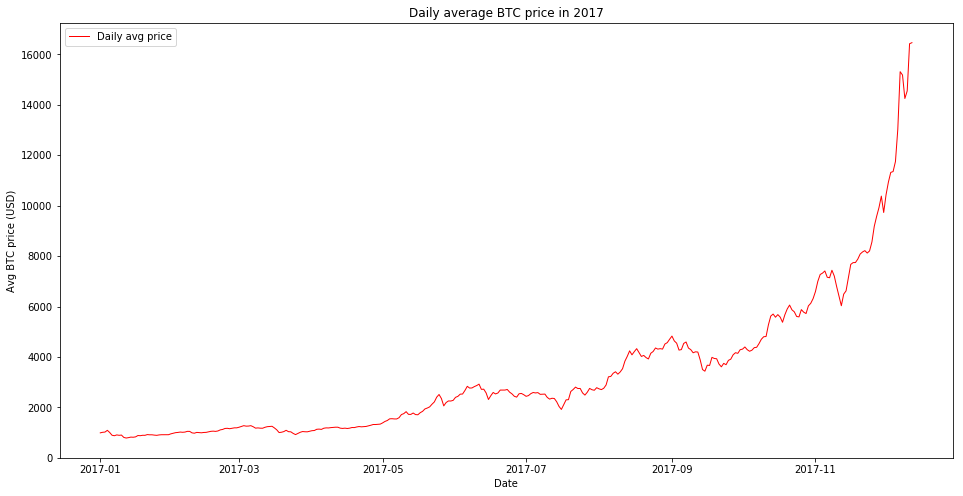

In [14]:
# Make the daily/hourly plot
btc = btc.sort_values("timestamp")
df = btc.groupby("date")["price"].agg(['mean']).rename(columns={'mean': 'price'})

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["price"], linewidth=1,
         color="red", label=r"Daily avg price")
plt.xlabel(r"Date")
plt.ylabel(r"Avg BTC price (USD)")
plt.title(r"Daily average BTC price in 2017")


plt.legend(loc="upper left")

plt.show()

#### Did the price increase or decrease at the close of the day?

In [15]:
# Add the time aggregation and OHLC funciton


def time_precision(series, precision):
    """
    Returns the date time series with a date time value floored to the 
    specified freq string
    """
    return (pd.DatetimeIndex(series)).floor(precision)


def make_ohlc(df, datetime_col, price_col, time_granularity):
    """
    Calculates the data for an OHLC chart from a df with a date_time and
    price columns, with intervals of time_granularity. Returns a DataFrame.
    """
    
    df = df.sort_values(datetime_col)    
    df["time_bracket"] = df[datetime_col].map(
        lambda x: time_precision(x, time_granularity))

    btc_ohlc = df.groupby("time_bracket")[price_col]\
        .agg(["first", "max", "min", "last", "median"])\
        .rename(columns={'first': 'open', 'max': 'high', "min": "low", "last": "close"})

    conditions = [(btc_ohlc['open'] <= btc_ohlc['close']),
                  (btc_ohlc['open'] > btc_ohlc['close'])]

    choices = ["up", "down"]

    btc_ohlc['price_change_label'] = np.select(conditions, choices)

    btc_ohlc["price_change_pct"] = 100 * \
        (btc_ohlc["close"] / btc_ohlc["open"] - 1)

    return (btc_ohlc)

In [16]:
btc_ohlc_24h = make_ohlc(btc,"date_time","price","1d")
btc_ohlc_6h = make_ohlc(btc,"date_time","price","6h")

In [17]:
btc_ohlc_6h.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-01-01 00:00:00-05:00,963.02,974.77,962.80,973.98,968.72,up,1.138086
2017-01-01 06:00:00-05:00,973.98,992.99,970.72,992.99,977.66,up,1.951785
2017-01-01 12:00:00-05:00,992.98,1004.88,981.57,1002.50,999.00,up,0.958730
2017-01-01 18:00:00-05:00,1002.40,1005.75,994.39,1005.73,999.50,up,0.332203
2017-01-02 00:00:00-05:00,1005.48,1024.00,1002.80,1020.00,1011.00,up,1.444086


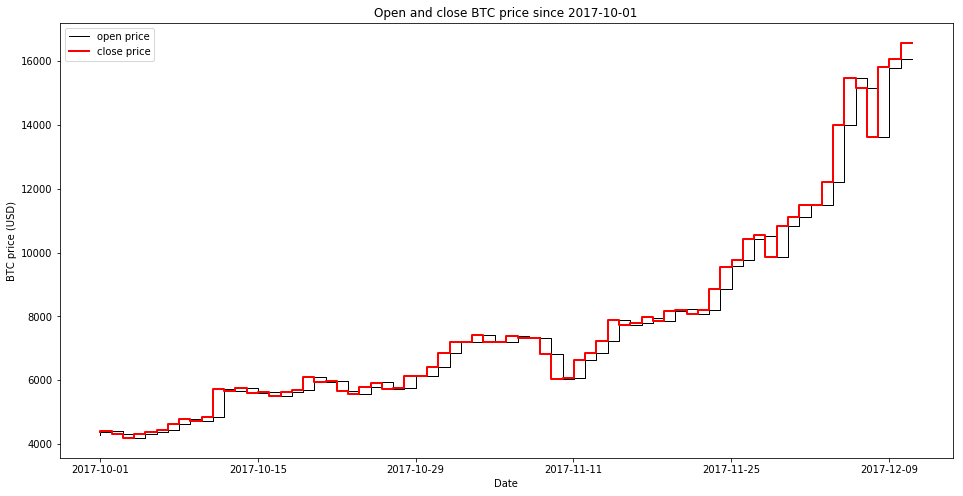

In [18]:
# Make the o-c plot
start_date = "2017-10-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Open and close BTC price since "+start_date)
plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")
plt.legend(loc="upper left")
plt.show()

In [188]:
start_date = "2017-06-01"
df = btc_ohlc_24h[pd.to_datetime(start_date).date():]

trace = go.Ohlc(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close,
               name = "BTC price")
data = [trace]
layout = dict(title = "Daily BTC price changes since "+start_date,
              yaxis = {'title': 'BTC Price USD'})
fig = dict(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [19]:
btc_ohlc_24h.groupby("price_change_label")["price_change_label"].count()

price_change_label
down    130
up      216
Name: price_change_label, dtype: int64

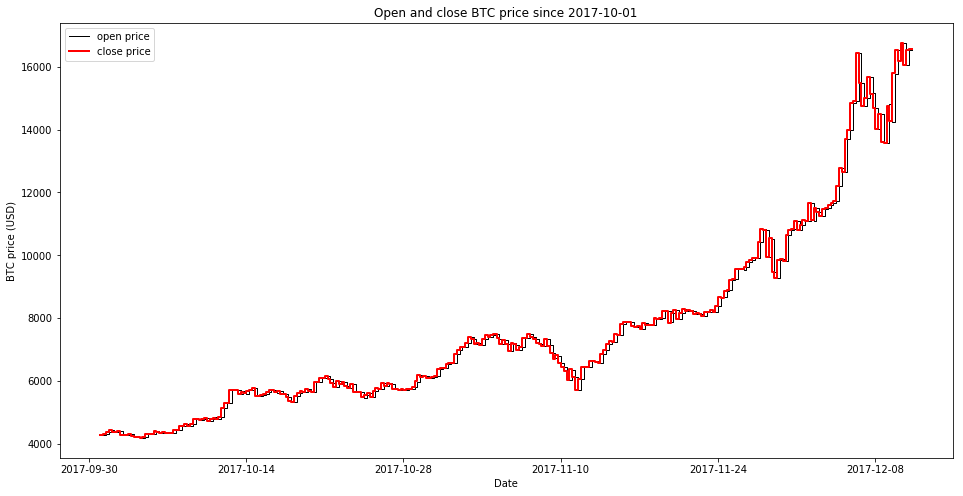

In [20]:
# Make the o-c plot
start_date = "2017-10-01"
df = btc_ohlc_6h[pd.to_datetime(start_date).date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Open and close BTC price since "+start_date)
plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")
plt.legend(loc="upper left")
plt.show()

In [21]:
btc_ohlc_24h.to_csv("processed_data/btc_ohlc_24.csv")
btc_ohlc_6h.to_csv("processed_data/btc_ohlc_6h.csv")

## The time aggregated DF used later for joining with Twitter is defined here:

In [22]:
time_aggr = "12h" ## Definition of the used time precision!
btc_ohlc = make_ohlc(btc,"date_time","price",time_aggr)

In [23]:
btc_ohlc.head(5)

,open,high,low,close,median,price_change_label,price_change_pct
time_bracket,,,,,,,
2017-01-01 00:00:00-05:00,963.02,992.99,962.80,992.99,975.400,up,3.112085
2017-01-01 12:00:00-05:00,992.98,1005.75,981.57,1005.73,999.170,up,1.284014
2017-01-02 00:00:00-05:00,1005.48,1032.00,998.72,1025.70,1020.005,up,2.010980
2017-01-02 12:00:00-05:00,1025.70,1029.92,990.01,1023.57,1013.000,down,-0.207663
2017-01-03 00:00:00-05:00,1023.59,1026.50,1009.08,1020.98,1018.890,down,-0.254985


### Get the Tweets

In [24]:
twt_path = "data/tweets2017.csv"
twt = pd.read_csv(twt_path)
twt.shape

(49212, 2)

In [25]:
twt.head(5)

,tweet,timestamp
0,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05
1,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19
2,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ ...,2017-03-31 21:04:50
3,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49
4,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03


### Question to clarify - what is the timezone of the twitter timestamps? What is the timezone of the bitcoin price data?

#### Clean the tweets from URLS, non-english characters, and duplicates

In [26]:
def isEnglish(s):
    """Checks if a string contains ASCII characters only.
    Source: https://stackoverflow.com/a/27084708/8066374
    """
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [27]:
# Clean the tweets
twt["tweet_proc"] = twt["tweet"].str.replace("https?://.*","") # remove all urls
twt["tweet_proc"] = twt["tweet_proc"].str.replace("’|#","") # remove non-unicode apostrophe and also hashtag sign
twt = twt[twt["tweet_proc"].str.len() >= 3] # retain only the tweets with more than 3 remaining characters
twt["is_english"] = twt["tweet_proc"].map(isEnglish)

In [28]:
twt.head(5)

,tweet,timestamp,tweet_proc,is_english
0,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,True
1,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,True
2,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ ...,2017-03-31 21:04:50,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ,False
3,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,True
4,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03,Federal Reserve official warns of digital curr...,True


In [29]:
twt.groupby(["is_english"])["tweet"].count()

is_english
False     8404
True     39725
Name: tweet, dtype: int64

Removed 8404 tweets with non-ascii characters to prepare the data for VADER sentiment analysis

In [30]:
twt_clean = twt[twt["is_english"]==True]

In [31]:
twt_clean = twt_clean.drop_duplicates("tweet_proc")

In [32]:
twt_clean.shape

(21649, 4)

Only 21.6k tweets remain after the cleaning step

#### Extract sentiment using NLTK and VADER

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

/Users/dima/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [34]:
print(twt_clean.loc[3,'tweet_proc'])
print(sid.polarity_scores(twt_clean.loc[3,'tweet_proc']))

How The Technology Behind Bitcoin Is Going To Change The Lives Of The Bottom Billion 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [35]:
twt_clean["sid"] = twt_clean["tweet_proc"].map(lambda x: sid.polarity_scores(x))

In [36]:
twt_clean = pd.concat([twt_clean.drop(["sid","tweet","is_english"], axis=1), 
                       twt_clean["sid"].apply(pd.Series)], axis=1)

In [37]:
twt_clean.head(10)

,timestamp,tweet_proc,compound,neg,neu,pos
0,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,-0.2960,0.180,0.820,0.000
1,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,-0.3612,0.152,0.848,0.000
3,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,0.0000,0.000,1.000,0.000
4,2017-03-31 22:08:03,Federal Reserve official warns of digital curr...,-0.3612,0.368,0.632,0.000
5,2017-03-31 22:13:59,Bitcoin : 'Blood Diamonds' Of The Digital Era ...,0.1759,0.145,0.639,0.217
6,2017-03-31 22:18:00,A Plan to Save Blockchain Democracy From Bitco...,-0.1779,0.277,0.496,0.227
7,2017-03-31 22:30:18,Digital asset exchange ShapeShift raises $10.4...,0.3612,0.000,0.762,0.238
8,2017-03-31 22:31:14,How an Anarchist Bitcoin Coder Found Himself F...,-0.3612,0.200,0.800,0.000
11,2017-04-01 00:03:18,Reg now behind invisible HTML5 Bitcoin paywall,0.0000,0.000,1.000,0.000
13,2017-04-01 01:03:10,Rising value of ethereum Turning a corner? Is ...,0.4137,0.000,0.784,0.216


#### Visualize the daily sentiment over time

In [38]:
twt_clean.head(1)

,timestamp,tweet_proc,compound,neg,neu,pos
0,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,-0.296,0.18,0.82,0.0


In [39]:
# Extract time components 
twt_clean["date_time"] = pd.to_datetime(twt_clean["timestamp"])
# twt_clean["date"] = twt_clean["date_time"].dt.date

# Add the time granularity required for the join with the price data
twt_clean["time_bracket"] = (pd.DatetimeIndex(twt_clean["date_time"],tz="America/New_York")).floor(time_aggr)

# Get daily total for the VADER scores
twt_clean_agg = twt_clean[["time_bracket","neg","pos","compound"]].groupby(["time_bracket"]).sum()
twt_clean_agg.head()


,neg,pos,compound
time_bracket,,,
2017-03-31 12:00:00-04:00,1.322,0.682,-1.0204
2017-04-01 00:00:00-04:00,3.716,4.041,0.6680
2017-04-01 12:00:00-04:00,1.805,2.793,1.7499
2017-04-02 00:00:00-04:00,1.734,2.065,0.5411
2017-04-02 12:00:00-04:00,1.619,4.069,4.0718


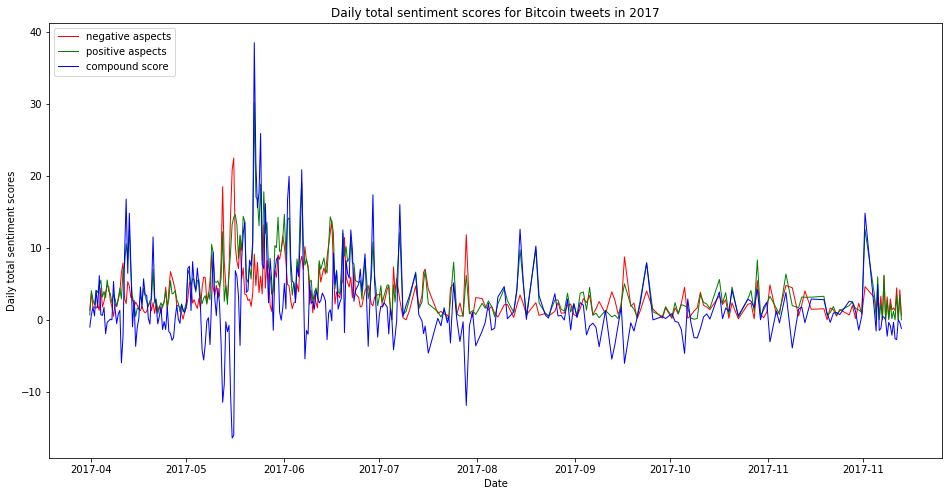

In [40]:
# Make a line plot
df = twt_clean_agg

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["neg"], linewidth=1,
         color="red", label=r"negative aspects")
plt.plot(df.index, df["pos"], linewidth=1,
         color="green", label=r"positive aspects")
plt.plot(df.index, df["compound"], linewidth=1,
         color="blue", label=r"compound score")
plt.xlabel(r"Date")
plt.ylabel(r"Daily total sentiment scores")
plt.title(r"Daily total sentiment scores for Bitcoin tweets in 2017")


# plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
#          color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Correlate the daily compound sentiment with the price change direction

In [41]:
# Sentiment differential
twt_clean_agg["sent_diff"] = 0.0

for s in range(1, len(twt_clean_agg.index)):
    twt_clean_agg["sent_diff"][s] = np.float(twt_clean_agg["compound"][s]-twt_clean_agg["compound"][s-1])
    
twt_clean_agg.head()

,neg,pos,compound,sent_diff
time_bracket,,,,
2017-03-31 12:00:00-04:00,1.322,0.682,-1.0204,0.0000
2017-04-01 00:00:00-04:00,3.716,4.041,0.6680,1.6884
2017-04-01 12:00:00-04:00,1.805,2.793,1.7499,1.0819
2017-04-02 00:00:00-04:00,1.734,2.065,0.5411,-1.2088
2017-04-02 12:00:00-04:00,1.619,4.069,4.0718,3.5307


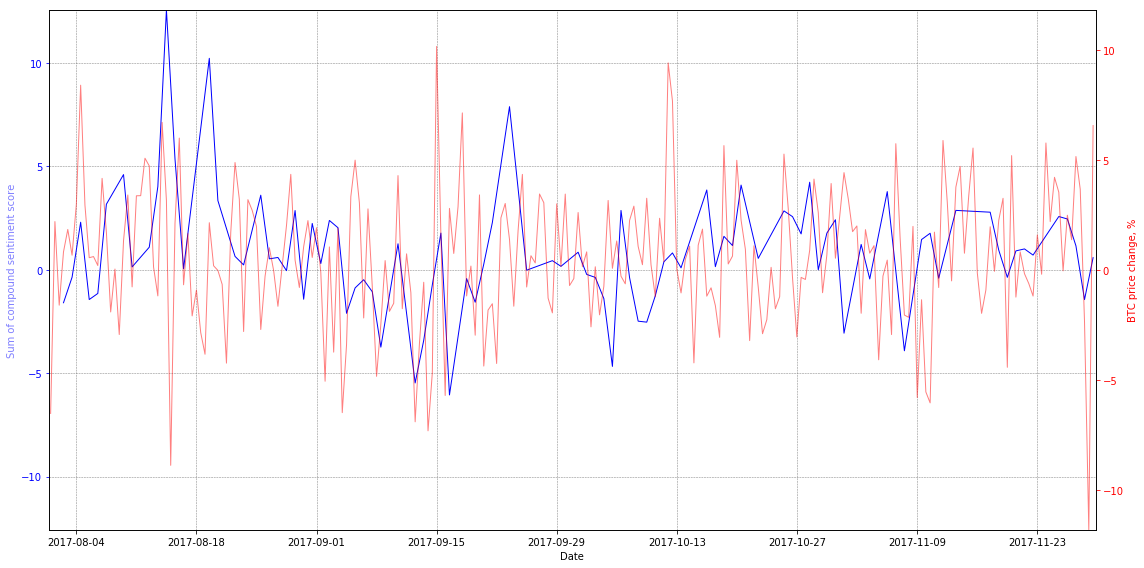

In [42]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

import datetime
#Zoom timeline
format = '%Y-%m-%d %H:%M:%S'
start = datetime.date(2017, 8, 1) #enter 'None' to see all left
end = datetime.date(2017, 12, 1) #enter 'None' to see all right

#Variables
twt_var = "compound"#"sent_diff"
btc_var = "price_change_pct"#close
df1 = df1[(df1.index >= pd.to_datetime(start, utc = True)) & (df1.index <= pd.to_datetime(end, utc = True))]
df2 = df2[(df2.index >= pd.to_datetime(start, utc = True)) & (df2.index <= pd.to_datetime(end, utc = True))]

#Force same y
twt_lim = max(abs(df1[twt_var]))
btc_lim = max(abs(df2[btc_var]))


fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(df1.index, df1[twt_var], linewidth=1,color="blue")
ax1.set_xlabel('Date')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Sum of compound sentiment score', color='blue', alpha = 0.5)
ax1.tick_params('y', colors='blue')
ax1.grid(color='grey', linestyle='--', linewidth=.5)
ax1.set_ylim(-twt_lim, twt_lim)
ax1.set_xlim(left = start, right = end)
#ax1.set_yscale("log", nonposy='clip')

ax2 = ax1.twinx()

ax2.plot(df2.index, df2[btc_var], linewidth=1,color="red", alpha = 0.5)
ax2.set_ylabel('BTC price change, %', color='red')
ax2.tick_params('y', colors='red')
ax2.set_xlim(left = start, right = end)
ax2.set_ylim(-btc_lim, btc_lim)
#ax2.set_yscale("log", nonposy='clip')

# ax3 = ax1.twinx()
# ax3 = ax1.twiny()
# ax3.plot(twt_clean_daily.index,np.repeat(0,len(twt_clean_daily.index)),
#          linewidth=1,color="black")

fig.tight_layout()
plt.show()

In [43]:
print(btc_ohlc.head(1))
print(twt_clean_agg.head(1))

                             open    high    low   close  median  \
time_bracket                                                       
2017-01-01 00:00:00-05:00  963.02  992.99  962.8  992.99   975.4   

                          price_change_label  price_change_pct  
time_bracket                                                    
2017-01-01 00:00:00-05:00                 up          3.112085  
                             neg    pos  compound  sent_diff
time_bracket                                                
2017-03-31 12:00:00-04:00  1.322  0.682   -1.0204        0.0


In [44]:
df1 = twt_clean_agg[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

btc_twt = pd.merge(df2.reset_index(),df1.reset_index(),"left")
btc_twt.shape

(511, 12)

In [45]:
# Check the periods with missing Twitter data
btc_twt[btc_twt.pos.isnull()].shape

(190, 12)

### Add features for price change in the previous and past period

In [46]:
btc_twt["price_change_pct_prev_period"] = btc_twt["price_change_pct"].shift(1)
btc_twt["price_change_pct_next_period"] = btc_twt["price_change_pct"].shift(-1)
btc_twt.head(3)

,time_bracket,open,high,low,close,median,price_change_label,price_change_pct,neg,pos,compound,sent_diff,price_change_pct_prev_period,price_change_pct_next_period
0,2017-04-01 00:00:00-04:00,1069.15,1097.0,1065.50,1073.65,1083.74,up,0.420895,3.716,4.041,0.6680,1.6884,NaN,0.101520
1,2017-04-01 12:00:00-04:00,1073.68,1085.0,1061.64,1074.77,1073.04,up,0.101520,1.805,2.793,1.7499,1.0819,0.420895,1.324004
2,2017-04-02 00:00:00-04:00,1074.77,1089.0,1066.49,1089.00,1076.58,up,1.324004,1.734,2.065,0.5411,-1.2088,0.101520,2.892562


### There are some days with no tweets in our dataset: decide what to do - remove or impute!

In [47]:
# Filter out the days with no twitter sentiment
btc_twt = btc_twt[btc_twt["compound"].notnull()]
btc_twt.shape

(321, 14)

221 daily observations remain if NaN twitter days are ignored

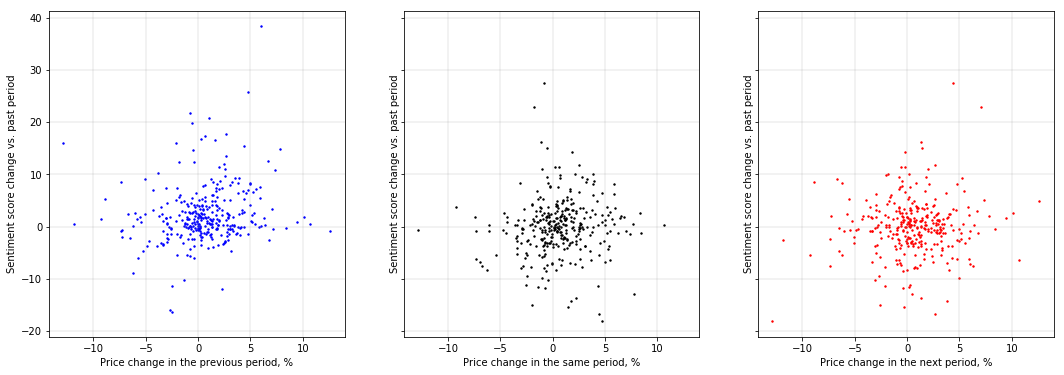

In [73]:
df = btc_twt

# fig, ax1 = plt.subplots(figsize=(8, 8))
fig, ((ax3, ax1, ax2)) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(18, 6))

#Twitter variable
twt_var = "sent_diff" #"compound"
# axis label
twt_axis_label = dict(sent_diff = "Sentiment score change vs. past period",
                     compound = "Compound sentiment total")


ax1.scatter(df["price_change_pct"], df[twt_var], color="black",s=2)
ax1.set_xlabel('Price change in the same period, %')
ax1.set_ylabel(twt_axis_label[twt_var])
ax1.grid(color='grey', linestyle='-', linewidth=0.2)

ax2.scatter(df["price_change_pct_next_period"], df[twt_var], color="red",s=2)
ax2.set_xlabel('Price change in the next period, %')
ax2.set_ylabel(twt_axis_label[twt_var])
ax2.grid(color='grey', linestyle='-', linewidth=0.2)

ax3.scatter(df["price_change_pct_prev_period"], df["compound"], color="blue",s=2)
ax3.set_xlabel('Price change in the previous period, %')
ax3.set_ylabel(twt_axis_label[twt_var])
ax3.grid(color='grey', linestyle='-', linewidth=0.2)

plt.show()

### Check the correlations

In [71]:
correlations = btc_twt[["price_change_pct_prev_period","price_change_pct","price_change_pct_next_period",
         "sent_diff","compound","pos","neg"]].corr()

correlations.iloc[0:3,3:]

,sent_diff,compound,pos,neg
price_change_pct_prev_period,0.116194,0.164141,0.061595,-0.067275
price_change_pct,0.064754,0.094282,0.003397,-0.089486
price_change_pct_next_period,0.075653,-0.014117,-0.000686,0.001027


We can see that the highest correlations between the price variables and sentiment variables are achieved between:
  
* the compound sentiment in the current period and the price change vs. the past period (r = +0.164)
* the change in sentiment and the price change vs. the past period (r = +0.116)

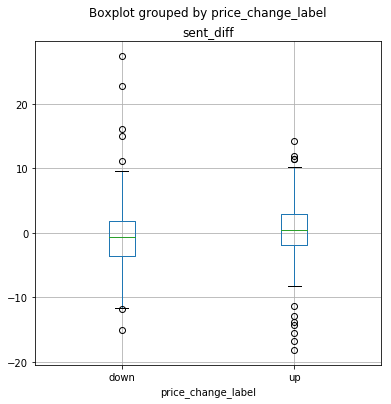

In [74]:
btc_twt.boxplot(column=twt_var,by='price_change_label',figsize=(6, 6))

### Next steps
  
Dima  
1. Get numeric feature for the price (rolling X hours) - daily and time-period (make function)

Liam
2. Get more Twitter data (to close the days with the gaps) - try switching off Top Tweets
3. Get more Twitter data - from "news" 

Tomorrow
4. Inspect correlations between sentiment and price response (also time-shifted)
5. Maybe - if we see correlation - come up with a model to predict the response

Optional
1. Word frequency distribution from the tweets (also separately for positive and negative tweets)

### Word Frequency Analysis

Look at high frequency words when the price differential is large, to see if the could be word usage signals to buy or sell.

In [52]:
# Get 1000 largest price differences since 2017/4/1
btc_large_diff = btc_ohlc[pd.to_datetime("2017-04-01").date():]
btc_large_diff["abs_price_change_pct"] = btc_large_diff["price_change_pct"].abs()
btc_large_diff = btc_large_diff.nlargest(100, "abs_price_change_pct")

#Get start time of time frame
btc_large_diff["timestart"] = [t.replace(tzinfo = None) for t in btc_large_diff.index]

In [53]:
btc_large_diff.head()

,open,high,low,close,median,price_change_label,price_change_pct,abs_price_change_pct,timestart
time_bracket,,,,,,,,,
2017-05-25 12:00:00-04:00,2686.02,2693.38,2221.00,2340.01,2398.99,down,-12.881885,12.881885,2017-05-25 12:00:00
2017-07-20 00:00:00-04:00,2324.99,2665.99,2303.20,2619.17,2529.00,up,12.652958,12.652958,2017-07-20 00:00:00
2017-11-30 00:00:00-05:00,10511.52,10581.95,9000.00,9269.00,9715.66,down,-11.820555,11.820555,2017-11-30 00:00:00
2017-12-06 12:00:00-05:00,12649.90,14095.00,12637.29,13999.00,13482.40,up,10.664906,10.664906,2017-12-06 12:00:00
2017-09-15 00:00:00-04:00,3359.95,3712.92,2972.01,3701.30,3267.13,up,10.159377,10.159377,2017-09-15 00:00:00


In [54]:
len(btc_ohlc_6h)

1382

In [55]:
twt_clean["future_price_diff"] = np.NaN

#Get future price change for respective tweet, if applicable
for t in twt_clean.index:
    if (btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')).any():
        twt_clean["future_price_diff"][t] = btc_large_diff.price_change_pct[
            btc_large_diff.timestart - twt_clean.date_time[t] <= pd.Timedelta('6 hours')][0]

# Drop NaNs
twt_large_diff = twt_clean.dropna()

In [56]:
twt_large_diff.head()

,timestamp,tweet_proc,compound,neg,neu,pos,date_time,time_bracket,future_price_diff
7378,2017-05-03 18:01:48,WhatsAppDown but bitcoin going Up Up Up,0.0000,0.000,1.000,0.000,2017-05-03 18:01:48,2017-05-03 12:00:00-04:00,5.50413
7382,2017-05-03 18:18:05,Missing out on Bitcoin ? Price surges to all-t...,-0.2960,0.180,0.820,0.000,2017-05-03 18:18:05,2017-05-03 12:00:00-04:00,5.50413
7383,2017-05-03 18:26:52,"Exactly 2 ys old, ripe 4 update Argentina's ne...",0.4939,0.000,0.833,0.167,2017-05-03 18:26:52,2017-05-03 12:00:00-04:00,5.50413
7387,2017-05-03 19:05:10,Frenzy pushes bitcoin to all-time highs:,-0.3182,0.315,0.685,0.000,2017-05-03 19:05:10,2017-05-03 12:00:00-04:00,5.50413
7388,2017-05-03 19:15:19,The world's biggest defense contractor Lockhee...,0.1280,0.000,0.909,0.091,2017-05-03 19:15:19,2017-05-03 12:00:00-04:00,5.50413


In [57]:
len(twt_large_diff)

18354

In [292]:
import nltk
from nltk.corpus import stopwords
from nltk.collocations import *

domain_stop_words = ["bitcoin","btc","blockchain","cryptocurrency","currency","new","digital","rt"]

stop_words = set(nltk.corpus.stopwords.words('german') +\
           nltk.corpus.stopwords.words('english') + domain_stop_words)

twt_diff_up = twt_large_diff[twt_large_diff.future_price_diff > 0]
twt_diff_down = twt_large_diff[twt_large_diff.future_price_diff < 0]

# Clean then tokenize tweets. Also, remove stop words
# For "up" related tweets

twt_tokens_up = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_up["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_up = [item for sublist in twt_tokens_up for item in sublist if item not in stop_words]
fdist_up = nltk.FreqDist(vocab_up)

# For "down" related tweets
twt_tokens_down = [nltk.tokenize.word_tokenize(t)
              for t in twt_diff_down["tweet_proc"].str.lower().replace(r'[^a-z\s]+','',regex=True)]
vocab_down = [item for sublist in twt_tokens_down for item in sublist if item not in stop_words]
fdist_down = nltk.FreqDist(vocab_down)

def top_bigrams(vocab,n):
    """
    Calculates the top n most frequent bigrams 
    in the vocabulary. Returns a sorted list with bigram and
    normalized frequency.
    """
    word_fd = nltk.FreqDist(vocab)
    bigram_fd = nltk.FreqDist(nltk.bigrams(vocab))
    finder = BigramCollocationFinder(word_fd, bigram_fd)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    
    return([(" ".join(bigram),score) for bigram,score in scored[:n]])   

def make_freq_df(list_of_tuples):
    """Makes a Pandas DF from an output of FreqDist"""
    
    df = pd.DataFrame(list_of_tuples,columns=["token","frequency"])
    df["tf"] = df["frequency"]/df["frequency"].max()
    df["prob"] = df["frequency"]/df.shape[0]
    
    return(df)

In [293]:
# Need to normalize by vocab length or by the % of the maximum
print(len(twt_tokens_up), len(twt_tokens_down))

3547 14807


In [296]:
print(fdist_up.most_common(20),)

[('high', 293), ('first', 272), ('record', 263), ('time', 250), ('ethereum', 191), ('past', 187), ('price', 156), ('alltime', 139), ('market', 139), ('million', 130), ('soars', 121), ('worth', 117), ('surges', 116), ('could', 116), ('fintech', 115), ('ransomware', 111), ('gold', 103), ('hits', 97), ('cnbc', 96), ('news', 95)]


In [295]:
top_bigrams(vocab_up,10)

[('first time', 0.009352973070666907),
 ('alltime high', 0.005828664377372131),
 ('past first', 0.0044731610337972166),
 ('record high', 0.004337610699439725),
 ('market cap', 0.0036146755828664378),
 ('years ago', 0.0032080245797939636),
 ('fresh record', 0.0031176576902223027),
 ('ago youd', 0.002394722573649015),
 ('youd sitting', 0.0023495391288631843),
 ('bought years', 0.0022591722392915235)]

In [297]:
freq_up = make_freq_df(fdist_up.most_common())
freq_down = make_freq_df(fdist_down.most_common())

In [298]:
freq_up[:10]

,token,frequency,tf,prob
0,high,293,1.000000,0.063793
1,first,272,0.928328,0.059221
2,record,263,0.897611,0.057261
3,time,250,0.853242,0.054431
4,ethereum,191,0.651877,0.041585
5,past,187,0.638225,0.040714
6,price,156,0.532423,0.033965
7,alltime,139,0.474403,0.030263
8,market,139,0.474403,0.030263
9,million,130,0.443686,0.028304


In [299]:
freq_down[:10]

,token,frequency,tf,prob
0,ethereum,1144,1.000000,0.092288
1,bubble,685,0.598776,0.055260
2,could,541,0.472902,0.043643
3,price,511,0.446678,0.041223
4,says,507,0.443182,0.040900
5,high,488,0.426573,0.039368
6,gold,458,0.400350,0.036947
7,fintech,451,0.394231,0.036383
8,business,449,0.392483,0.036221
9,via,437,0.381993,0.035253


In [300]:
# Make a chart with top words associated with UP and DOWN

df1 = freq_up[:20].sort_values("tf",ascending=True)
df2 = freq_down[:20].sort_values("tf",ascending=True)
x = "prob"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease',
                     legend=dict(orientation="h"))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [301]:
# Make a chart with top bigrams
up_bigrams = make_freq_df(top_bigrams(vocab_up,20))
down_bigrams = make_freq_df(top_bigrams(vocab_down,20))

In [304]:
df1 = up_bigrams[:20].sort_values("frequency",ascending=True)
df2 = down_bigrams[:20].sort_values("frequency",ascending=True)
x = "frequency"
y = "token"
text = x

trace1 = go.Bar(
            x=df1[x],
            y=df1[y],
            text= (df1[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(0,255,120,0.5)',
            ),
            orientation = 'h',
            name = "Price increased"
        )
trace2 = go.Bar(
            x=df2[x],
            y=df2[y],
            text=(df2[text]*100).round(1).astype("str")+"%",
            textposition = 'inside',
            marker=dict(
                color='rgba(255,0,0,0.5)',
            ),
            orientation = 'h',
            name = "Price decreased"
        )

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(height=600, width=900, title='Top terms associated with BTC price increase/decrease',
                     legend=dict(orientation="h"),margin=dict(l=120))
fig['layout']["yaxis1"].update(tickfont=dict(size=14))
fig['layout']["yaxis2"].update(tickfont=dict(size=14))

iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html  
http://mple.m-artwork.eu/tutorial  
Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374  
NLTK & Vader http://www.nltk.org/howto/sentiment.html  
Pandas dict to columns https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns  
Matplotlib multiple axes https://matplotlib.org/examples/api/two_scales.html  
Bigram analysis in NLTK http://www.nltk.org/howto/collocations.html  
Plotly Reference https://plot.ly/python/